# Recurrent Neural Network Simulating a Dynamic System

In [1]:
! pip3 install sympy matplotlib

## 1. Definition of a Dynamic Process

Classes DynamicModel and DynamicProcess are defined file DynamicSystem.py. DynamicModel holds a description of a dynamic system in a symbolic form and as a differential equation. DynamicProcess helps to model a response (time series) of such model for a random input.   

In [2]:
from sympy.abc import s, t, y, x, y, z

In [3]:
from DynamicSystem import DynamicModel, DynamicProcess

### 1.1 Symbolic Definition of a Chosen System

In [4]:
G = 5*(s+1)/((s+3)*(s+2))
dynamic_model = DynamicModel(G)

In [5]:
dynamic_process = DynamicProcess(dynamic_model, 100)
dynamic_process.model

(5*s + 5)/((s + 2)*(s + 3))

### 1.2. Example of system responses for different inputs 

In [6]:
import matplotlib.pyplot as plt
import numpy as np

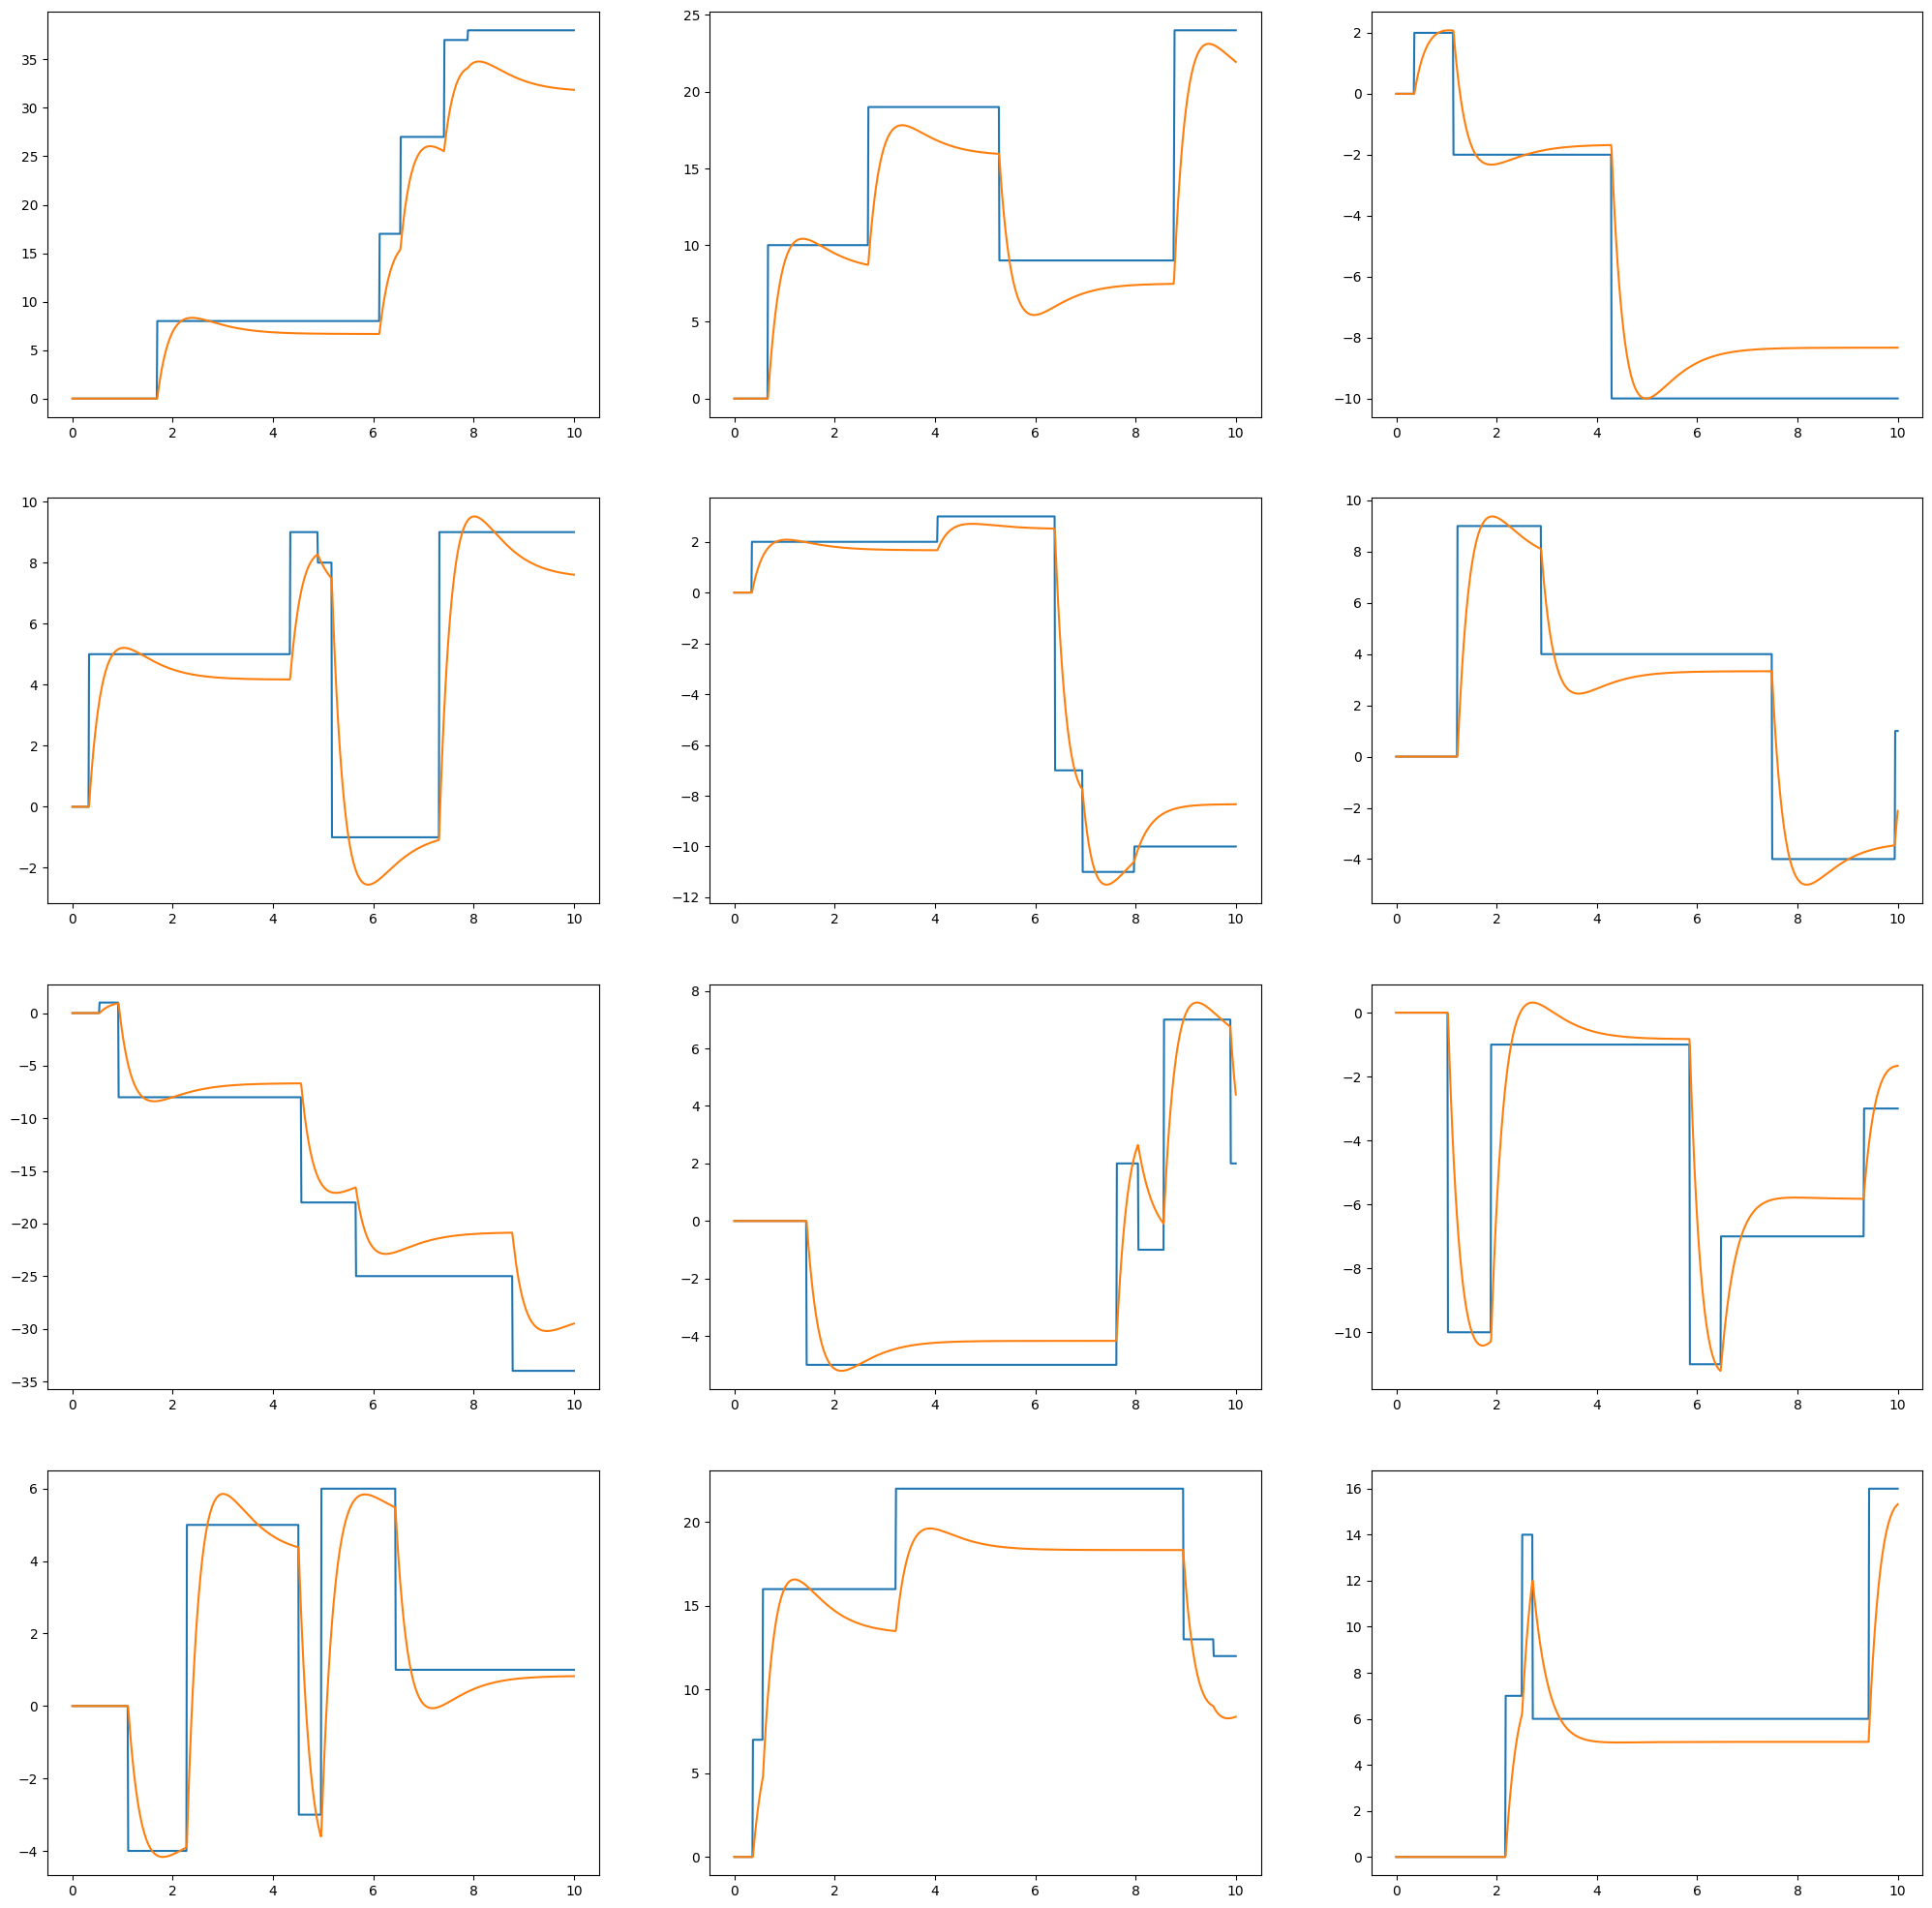

In [7]:
plt.figure(figsize=(25,25))
for i in range(12):
    t, u, y = dynamic_process.generate_time_series(10, 1000, new_inputs=True)
    plt.subplot(4,3,i+1)
    plt.plot(t, u)
    plt.plot(t, y)
plt.show()

## 2. Generate Dataset

In [8]:
import pandas as pd
import os
import pymongo

In [11]:
# Set up pymongo client
client = pymongo.MongoClient('localhost', 27017)
db = client.DynamicSystem
time_series_collection = db.time_series 

In [144]:
start = 20
stop = 40
for i in range(start, stop):
    t, u, y = dynamic_process.generate_time_series(10, 1000, new_inputs=True)
    data = {'t':t, 'u':u, 'y':y}
    df = pd.DataFrame(data)
    
    # Save to csv
    df.to_csv(f'dataset/{i}.csv', index=False)
    
    # Save to pymongo
    # time_series_collection.insert_one(df.to_json())

### 2.1. Prepare Dataset

In [9]:
import tensorflow as tf
from tensorflow import keras

2022-10-16 22:21:20.701223: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-16 22:21:21.440939: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-16 22:21:21.440961: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-16 22:21:21.523102: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-16 22:21:23.236902: W tensorflow/stream_executor/platform/de

#### 2.1.1. Import files

#### 2.1.2. Normalization and split

In [145]:
dataset_path = 'dataset/'
dataset_files = [ f'{dataset_path}/{file}' for file in os.listdir(dataset_path) if 'csv' in file]

val_samples = round(len(dataset_files) * 0.2)
train_ds = dataset_files[:-val_samples]
val_ds = dataset_files[-val_samples:]

In [11]:
def normalize_dataset(files):
    
    # Concatante data from every file 
    
    # Calculate normalized values
    
    # Save them as additional columns
    
    
    pass

### 2.1. BatchBuilder

In [146]:
class TimeSeriesBatchBuilder(keras.utils.Sequence):
    """_summary_
    Helps to iterate over the dataset
    Args:
        keras (_type_): _description_
    """

    def __init__(self, dataset_files, window_size):
        self.dataset_files = dataset_files
        self.window_size = window_size
        self.file_len = len(pd.read_csv(self.dataset_files[0]))
        self.batch_size = self.file_len / self.window_size
        self.mean = 0 
        self.std = 0
    
    def __len__(self):
        return len(self.dataset_files)

    def __getitem__(self, idx):
        """Returns tuple (input, output) that corresponds to batch idx"""
        
        i = idx * self.batch_size
        batch_file = pd.read_csv(self.dataset_files[idx])
        
        x, y = [], []
        end = self.file_len - self.window_size
        for i in range(self.window_size, end):
            x.append(batch_file['u'][i:i+self.window_size].values)
            y.append(batch_file['y'][i+self.window_size])
        
        return np.array(x, dtype=np.float32), np.array(y, dtype=np.float32)

In [150]:
window_size = 5
train_gen = TimeSeriesBatchBuilder(train_ds, window_size=15)
val_gen = TimeSeriesBatchBuilder(val_ds, window_size=15)

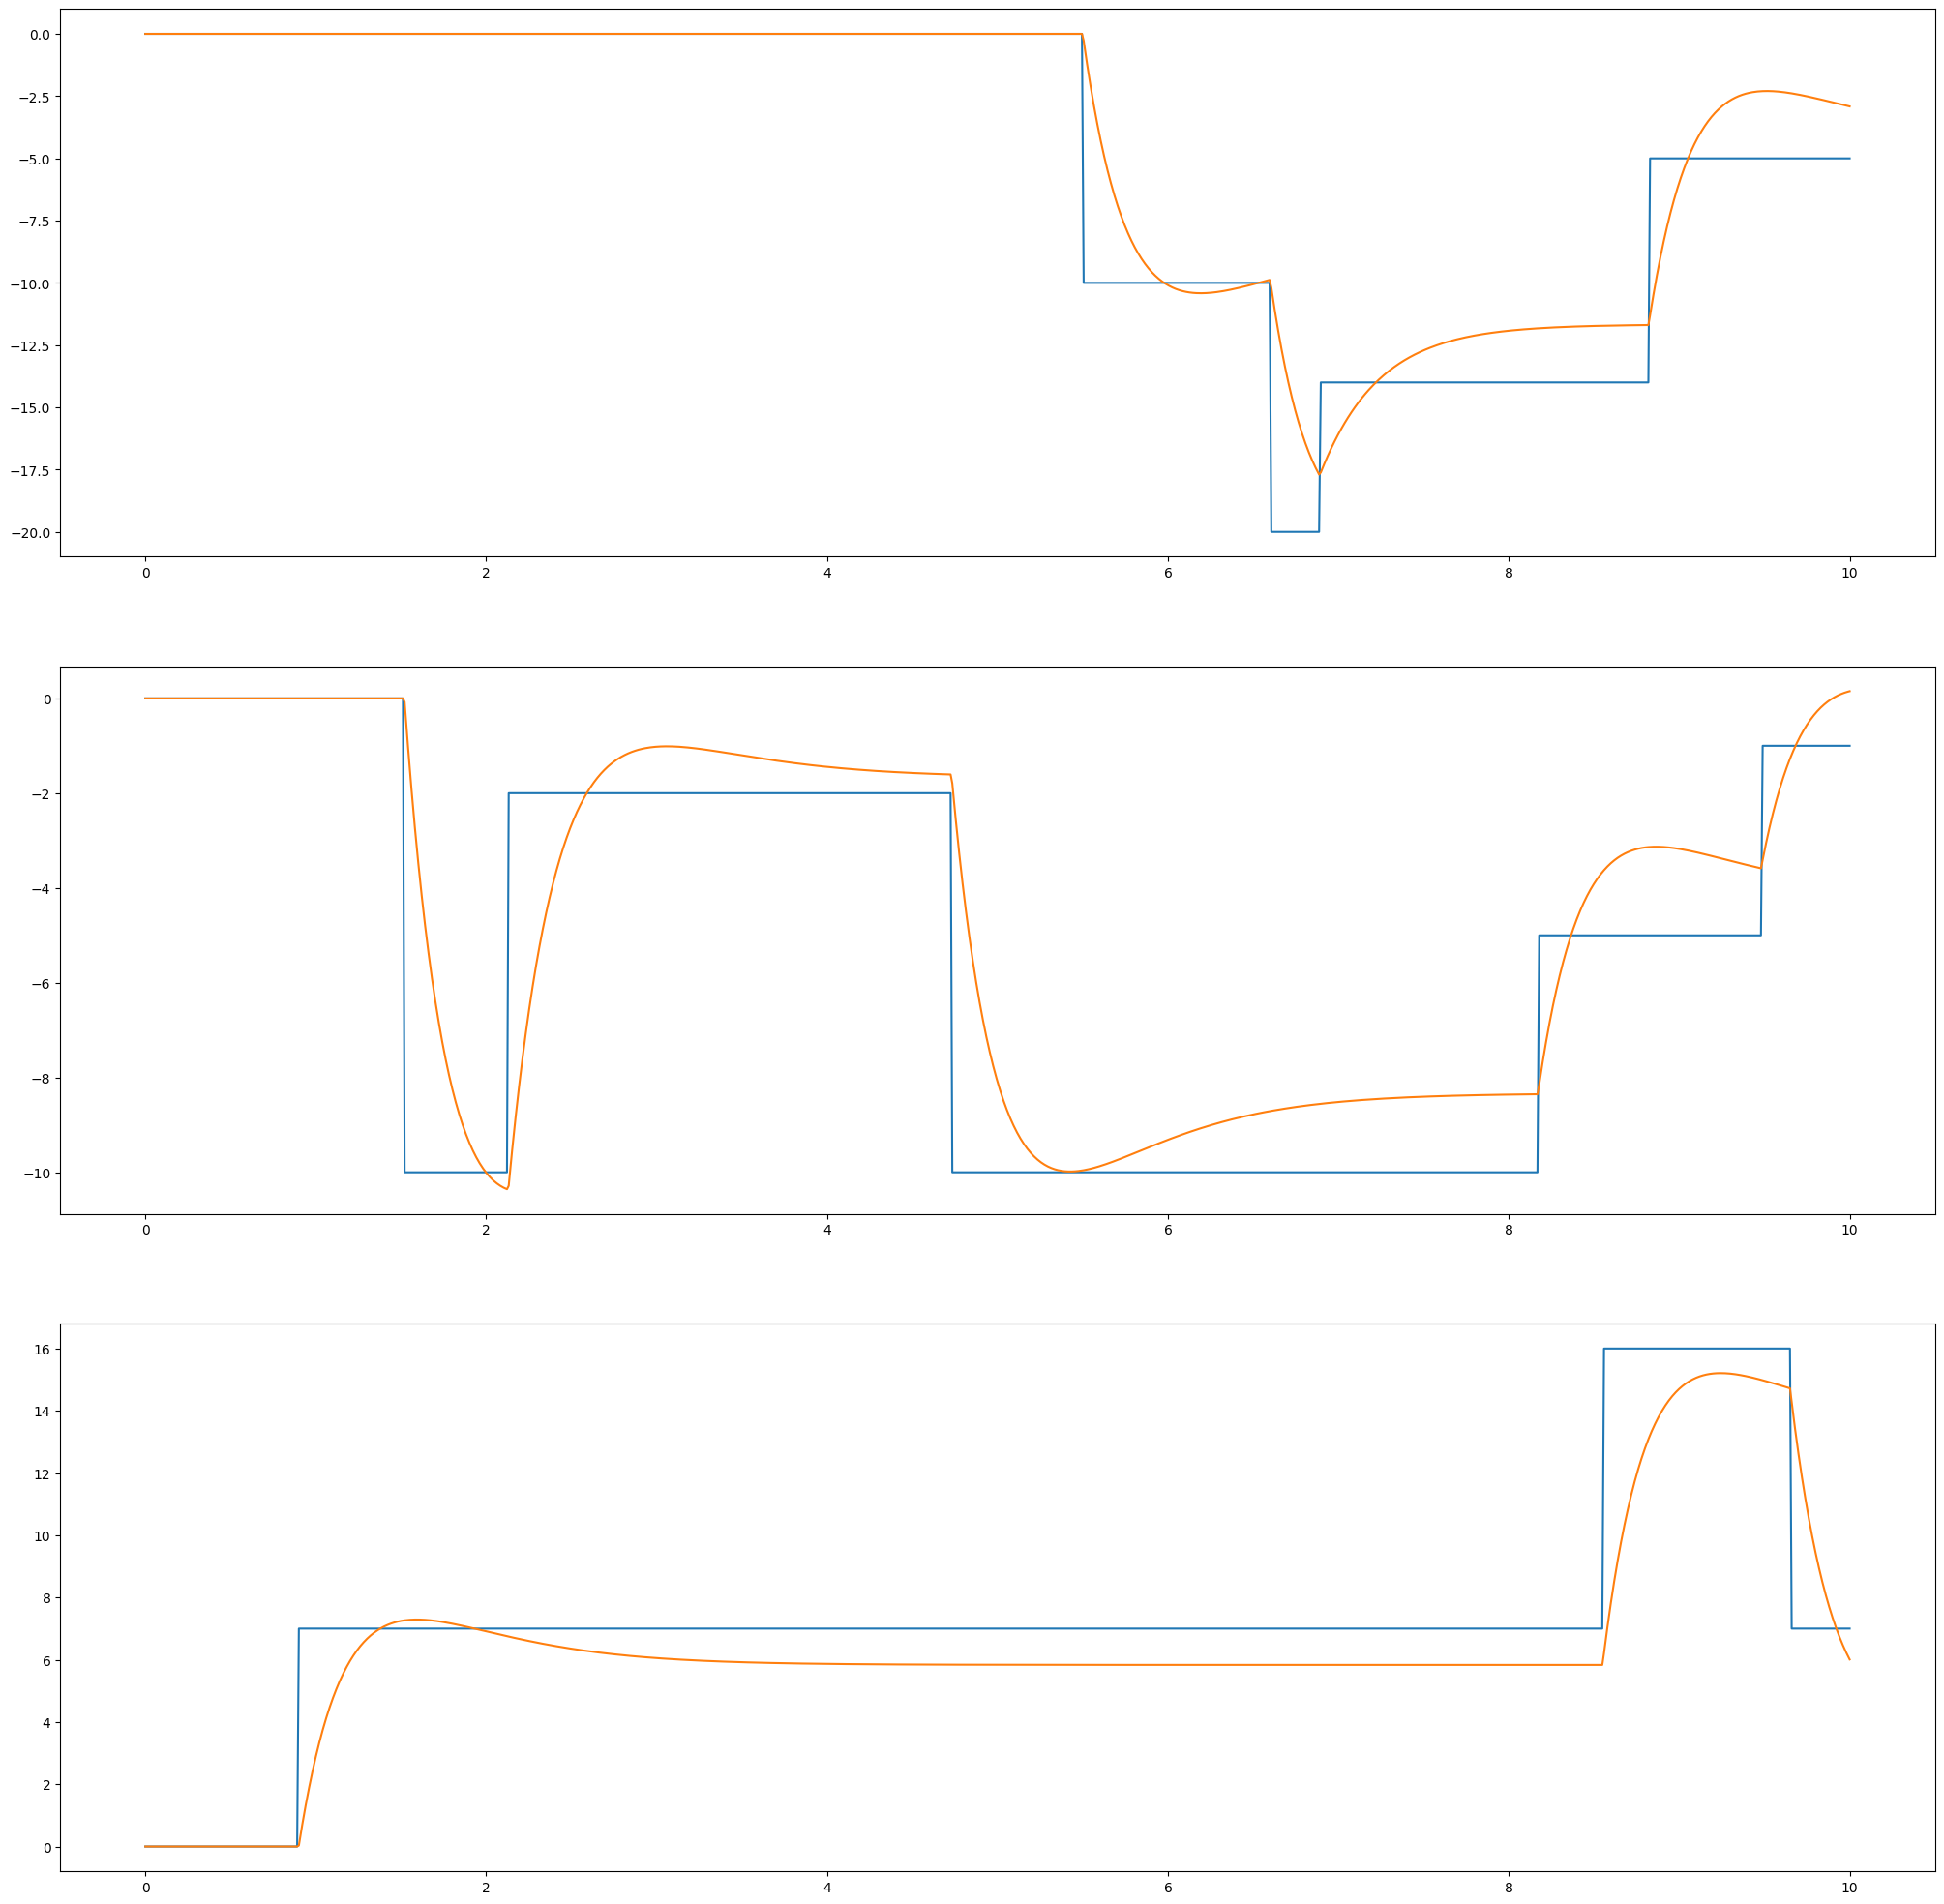

In [53]:
plt.figure(figsize=(25,25))
u, y = train_gen.__getitem__(1)
t = ts = np.linspace(0,10,1000)
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(t, u[i])
    plt.plot(t, y[i])
plt.show()

### 2.2. WindowGenerator

Create WindowGenerator object for each batch? 

In [55]:
class WindowGenerator:
    
    def __init__(self, dataset_path, split=(.6, .2, .2)):
        self.dataset_path = dataset_path
        dataset_files = [ f'{dataset_path}/{file}' for file in os.listdir(dataset_path)]
        self.total_window_size = 100
        self.train_df = pd.read_csv(dataset_files[0])
        self.val_df = pd.read_csv(dataset_files[1])
        self.test_df = pd.read_csv(dataset_files[2])
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}
        
    def split_window(self, features):
        pass
    
    def plot(self):
        pass
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)

        ds = ds.map(self.split_window)

        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result


In [56]:
window = WindowGenerator('dataset')

In [57]:
window.train_df

,t,u,y
0,0.00000,0.0,0.000000
1,0.01001,0.0,0.000000
2,0.02002,0.0,0.000000
3,0.03003,0.0,0.000000
4,0.04004,0.0,0.000000
...,...,...,...
995,9.95996,7.0,5.833300
996,9.96997,2.0,5.588999
997,9.97998,2.0,5.353300
998,9.98999,2.0,5.127001


### Prepare Baseline model for benchmarking

In [159]:
class BaseLine(tf.keras.Model):
    
    def __init__():
        pass
    
    def call():
        return 'test'

## 3. Prepare Data

## 4. Recurrent Neural Network

### 4.1. Standard LSTM network

In [74]:
import tensorflow as tf
from keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.models import Sequential

In [153]:
def rnn_model():
    
  model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(40, return_sequences=True),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dense(1),
  ])

  return model
  
  
def rnn_model_2(params, input_shape):
  model = Sequential()
  model.add(LSTM(units=params["lstm_units"], return_sequences=True, input_shape=(input_shape, 1)))
  model.add(Dropout(rate=params["dropout"]))

  model.add(LSTM(units=params["lstm_units"], return_sequences=True))
  model.add(Dropout(rate=params["dropout"]))

  model.add(LSTM(units=params["lstm_units"], return_sequences=True))
  model.add(Dropout(rate=params["dropout"]))

  model.add(LSTM(units=params["lstm_units"], return_sequences=False))
  model.add(Dropout(rate=params["dropout"]))

  model.add(Dense(1))

  model.compile(loss=params["loss"],
                optimizer=params["optimizer"],
                metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

  return model

def rnn_model_3():
  learning_rate = 0.001
  batch_size = 256
  epochs = 10
    
  model = Sequential()
  model.add(keras.layers.Input(shape=(15, 1)))
  model.add(keras.layers.LSTM(64, return_sequences=True))
  model.add(keras.layers.LSTM(32, return_sequences=True))
  model.add(keras.layers.Dense(1))
  
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
  model.summary()
    
  return model 
  
  

In [156]:
model = rnn_model_3()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 15, 64)            16896     
                                                                 
 lstm_28 (LSTM)              (None, 15, 32)            12416     
                                                                 
 dense_8 (Dense)             (None, 15, 1)             33        
                                                                 
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


In [157]:
history = model.fit(train_gen, epochs=20, validation_data=val_gen)

Epoch 1/20
32/32 [==============================] - 11s 230ms/step - loss: 43.2156 - val_loss: 63.2889
Epoch 2/20
32/32 [==============================] - 7s 214ms/step - loss: 39.3203 - val_loss: 58.3454
Epoch 3/20
32/32 [==============================] - 7s 218ms/step - loss: 38.2476 - val_loss: 55.1321
Epoch 4/20
32/32 [==============================] - 7s 219ms/step - loss: 37.4083 - val_loss: 52.8811
Epoch 5/20
32/32 [==============================] - 8s 238ms/step - loss: 36.7465 - val_loss: 52.8748
Epoch 6/20
32/32 [==============================] - 7s 232ms/step - loss: 36.2624 - val_loss: 50.8599
Epoch 7/20
32/32 [==============================] - 8s 237ms/step - loss: 35.8081 - val_loss: 50.1404
Epoch 8/20
32/32 [==============================] - 7s 222ms/step - loss: 35.6901 - val_loss: 48.6984
Epoch 9/20
32/32 [==============================] - 10s 310ms/step - loss: 35.3448 - val_loss: 48.5885
Epoch 10/20
32/32 [==============================] - 6s 200ms/step - loss: 35.39

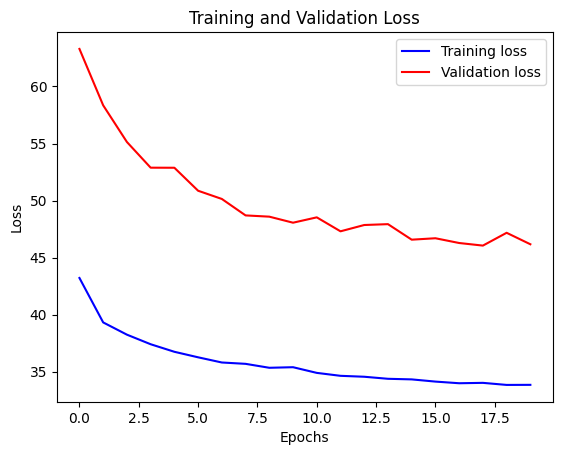

In [158]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

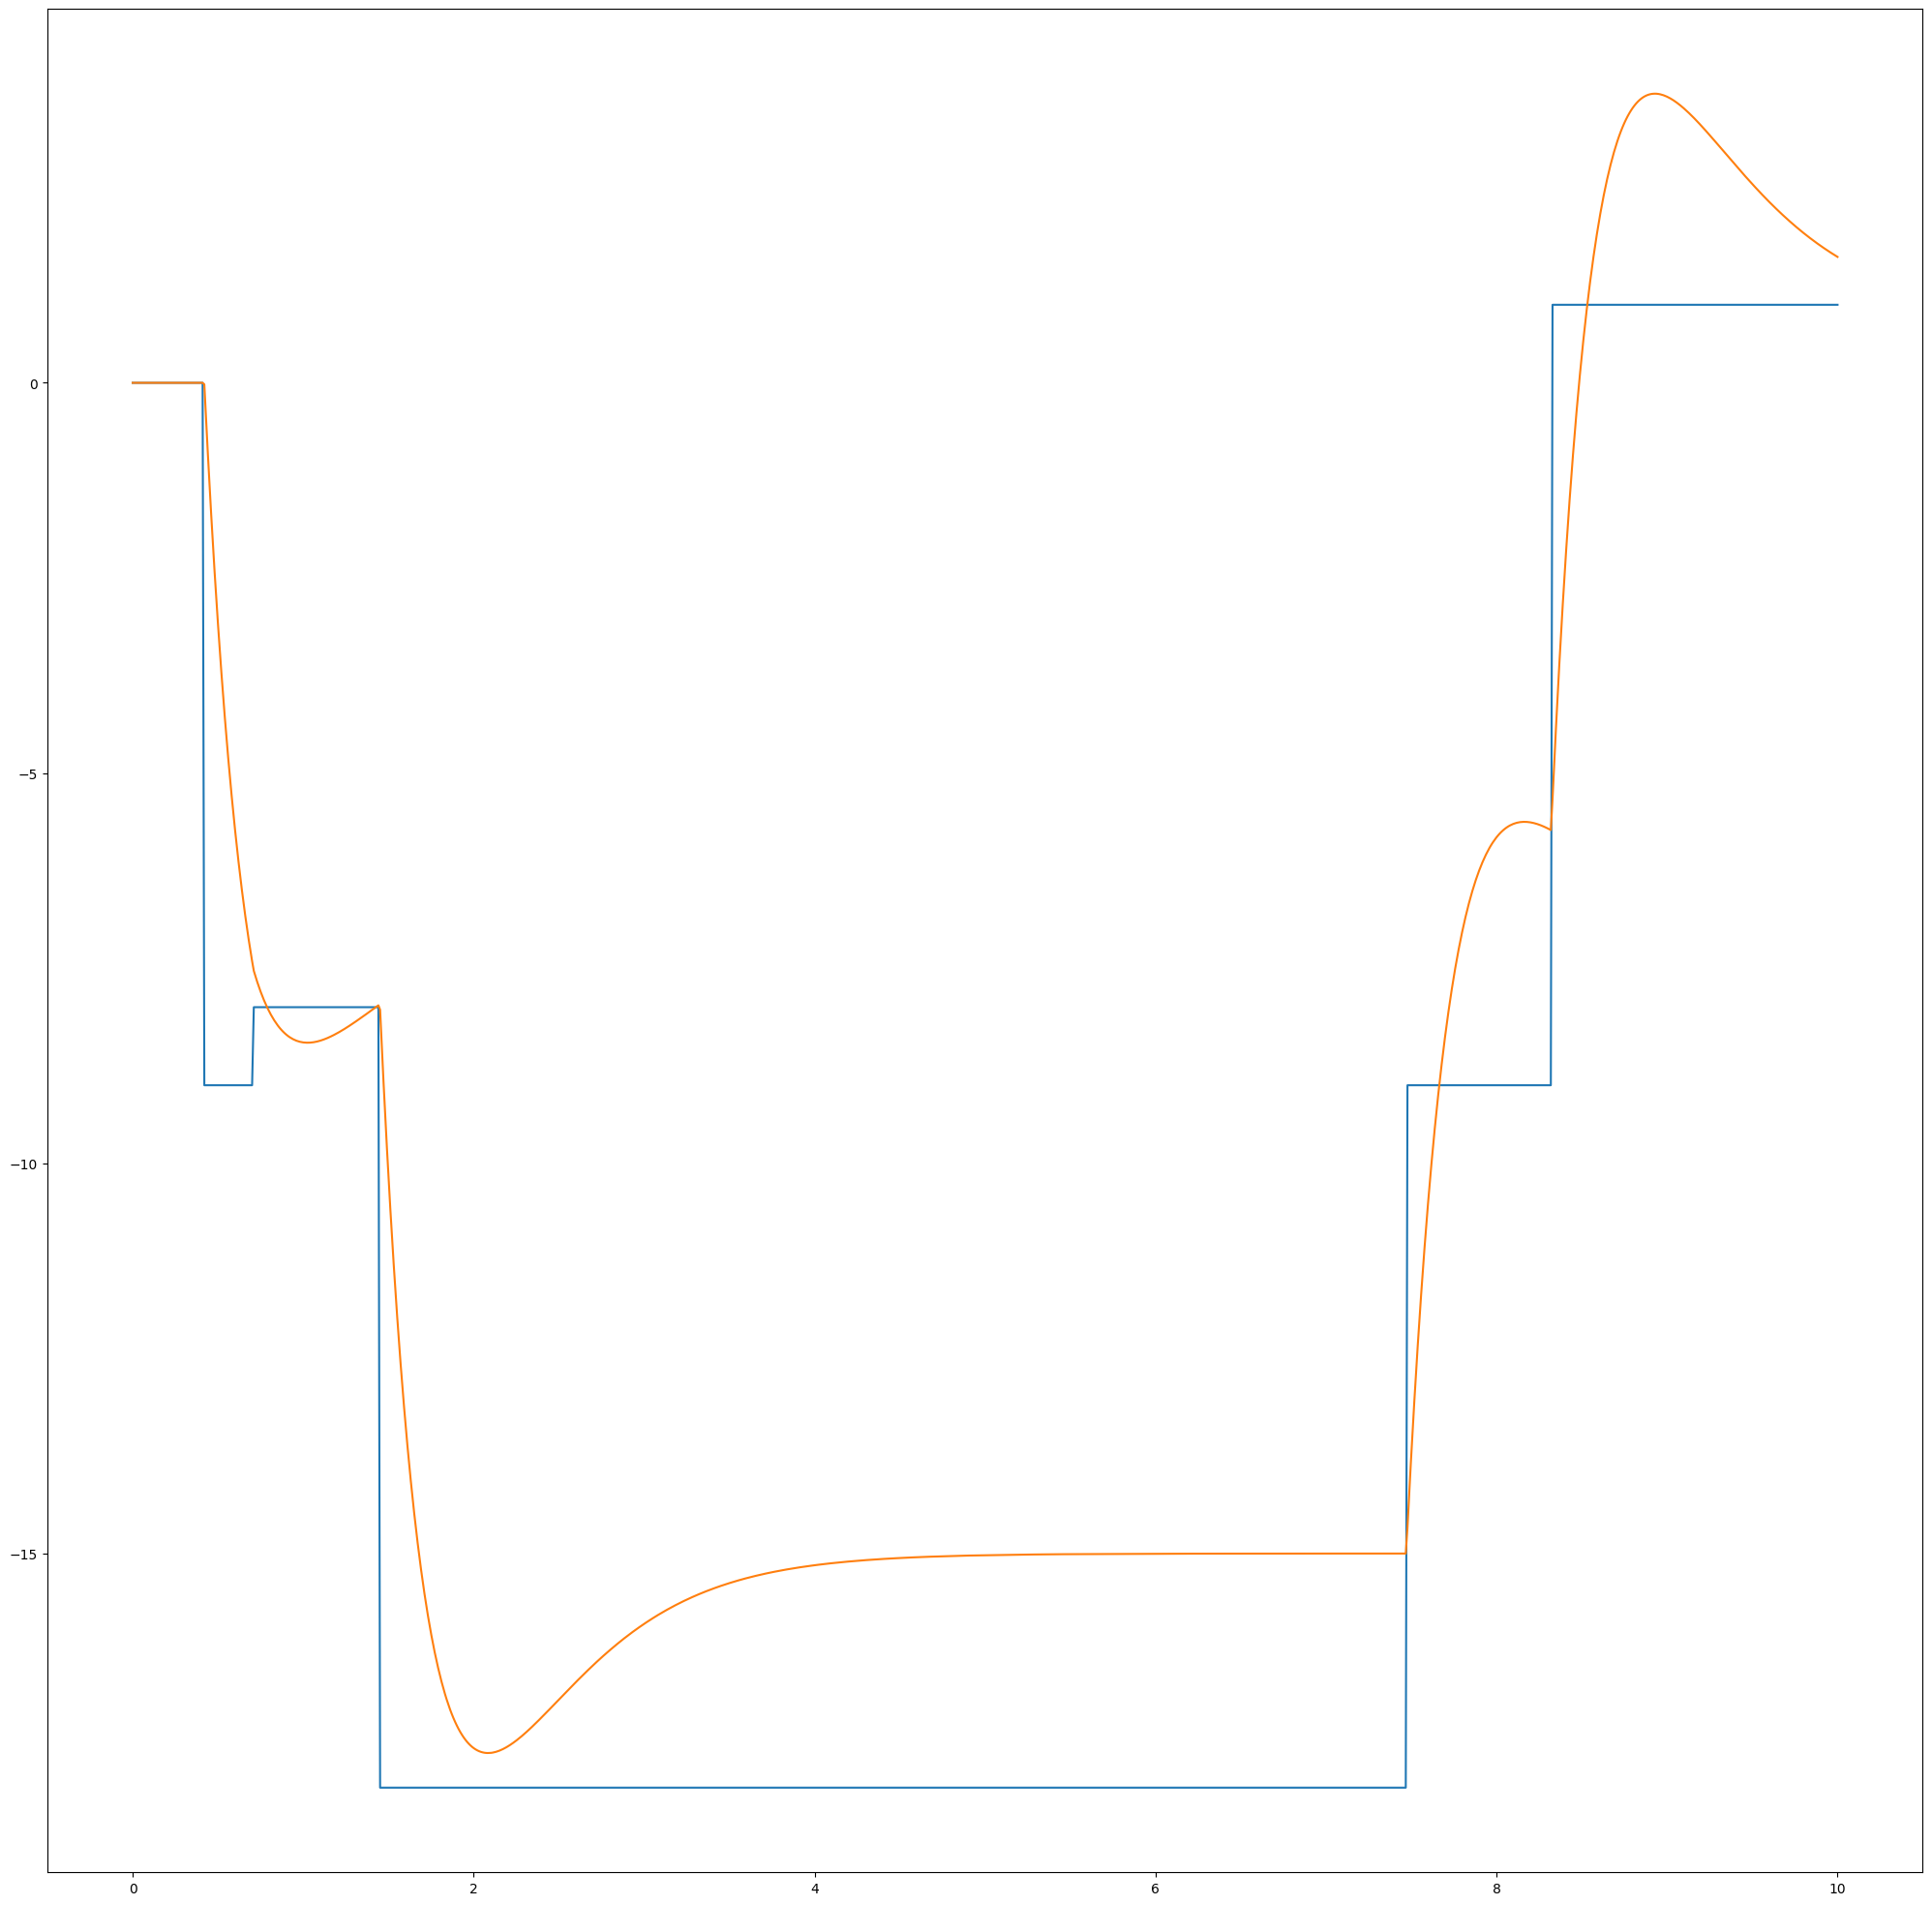

In [160]:
plt.figure(figsize=(25,25))
t, u, y = dynamic_process.generate_time_series(10, 1000, new_inputs=True)
plt.plot(t, u)
plt.plot(t, y)
plt.show()

In [163]:
total_len = len(t)
window_size = 15
y = []
end = total_len - window_size
for i in range(window_size, end):
    y_hat = model.predict(np.array([t[i:i+window_size]]))[0][0]
    y.append(y_hat)

print(len(y))

# model.predict(np.array([[0,0,0,0,0]]))
# np.array([0,0,0,0,0]).shape

1/1 [==============================] - 0s 29ms/step
970


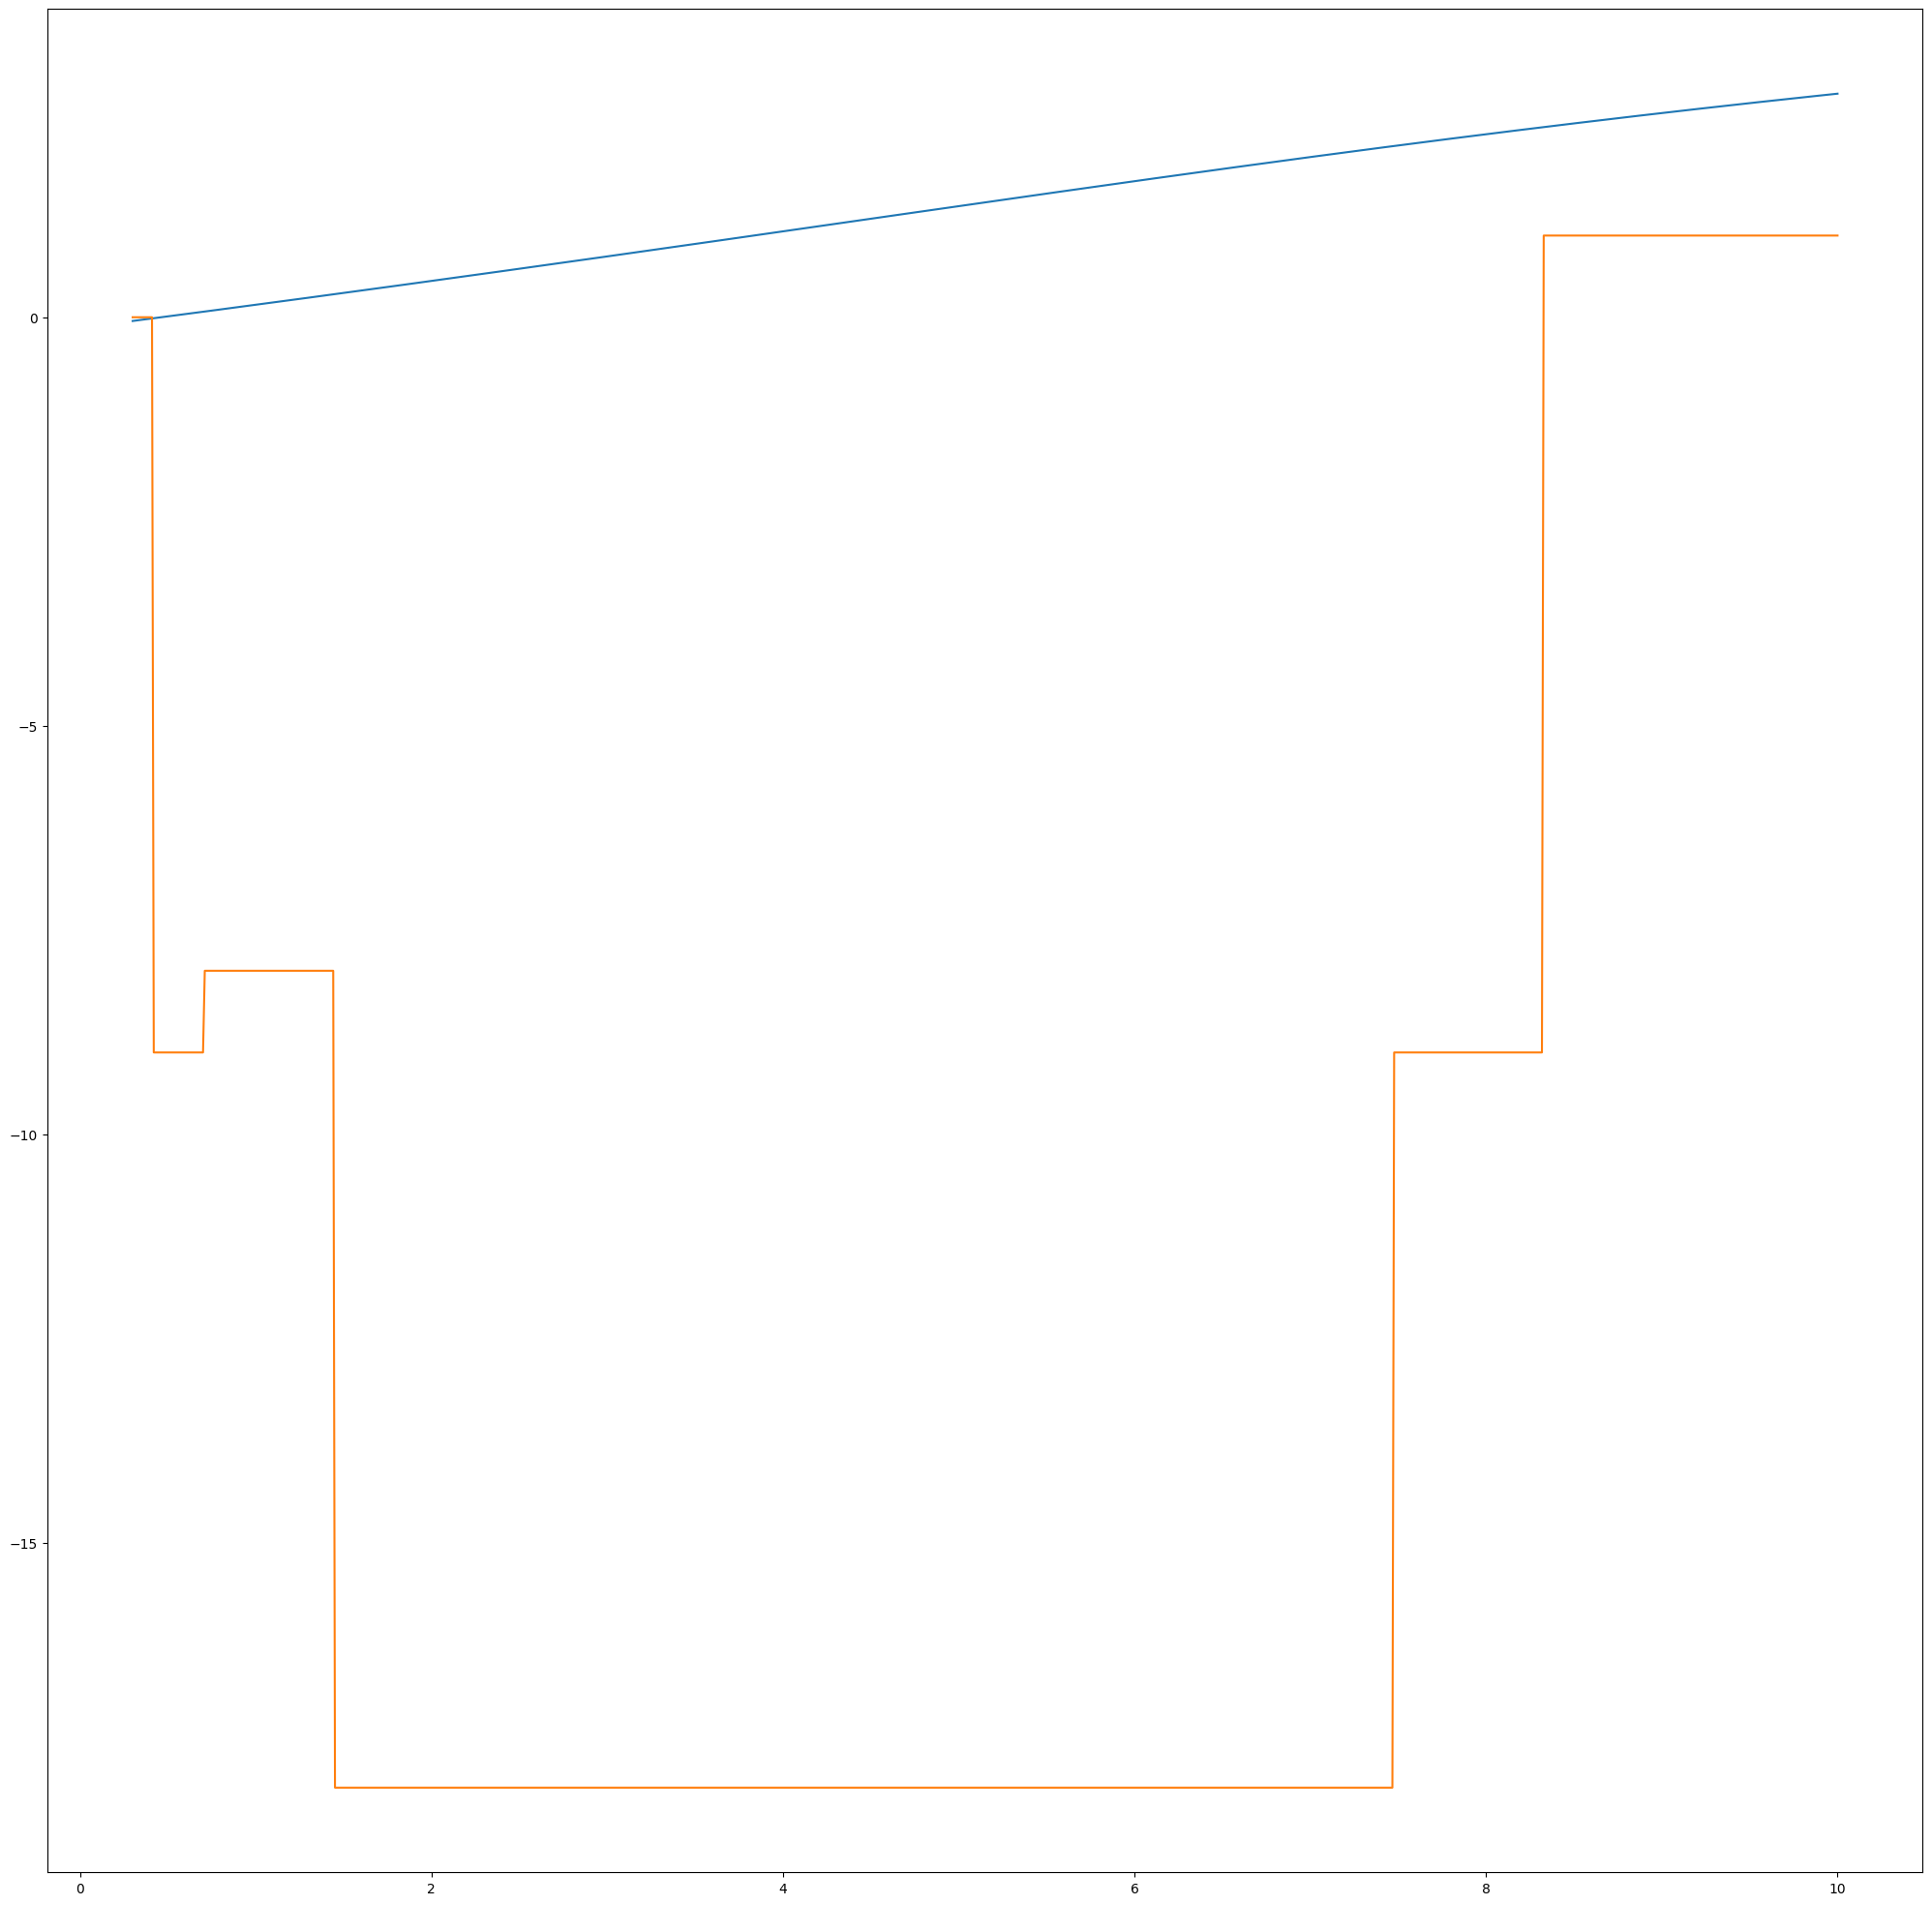

In [164]:
plt.figure(figsize=(25,25))
plt.plot(t[30:], y)
plt.plot(t[30:], u[30:])
plt.show()
# y

In [ ]:
params = {
	"loss": "mean_squared_error",
	"optimizer": "adam",
	"dropout": 0.2,
	"lstm_units": 90,
	"epochs": 30,
	"batch_size": 128,
	"es_patience" : 10
}

model = rnn_model_2(params=params, input_shape=1000)

In [ ]:
from pickletools import optimize


class DynamicSystemRNN(Model):
    def __init__(self, predictor, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.predictor = predictor
    
    def compile(self, optimizer, loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)
        
        self.optimzier = optimizer
        self.loss = loss 
    
    def train_step(self, batch):
        # Get data
        time_series = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Train the predictor
        with tf.GradientTape() as d_tape:
            for ts in batch:
                for step in ts:
                    y_prediction = self.predictor(step)
                    
            
            
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fake images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
        
            # Add some noise to the outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = 0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0) 
            
            # Calculate loss - BINARYCROSS
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagtion - nn learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator
        with tf.GradientTape() as g_tape:
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
            
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
            
            # Calculate loss
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [74]:
params = {
	"loss": "mean_squared_error",
	"optimizer": "adam",
	"dropout": 0.2,
	"lstm_units": 90,
	"epochs": 30,
	"batch_size": 128,
	"es_patience" : 10
}

model = rnn_model_2(params=params, input_shape=1000)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error',mode='min', patience=params["es_patience"])

In [76]:
history = model.fit(train_gen, epochs=15, validation_data=val_gen, callbacks=[es_callback])

Epoch 1/15
5/5 [==============================] - 10s 2s/step - loss: 30.4422 - root_mean_squared_error: 5.5174 - mean_absolute_error: 4.1408 - val_loss: 56.4520 - val_root_mean_squared_error: 7.5135 - val_mean_absolute_error: 6.3910
Epoch 2/15
5/5 [==============================] - 10s 2s/step - loss: 30.1224 - root_mean_squared_error: 5.4884 - mean_absolute_error: 4.1106 - val_loss: 56.4479 - val_root_mean_squared_error: 7.5132 - val_mean_absolute_error: 6.3699
Epoch 3/15
5/5 [==============================] - 10s 2s/step - loss: 28.4815 - root_mean_squared_error: 5.3368 - mean_absolute_error: 4.0225 - val_loss: 55.4250 - val_root_mean_squared_error: 7.4448 - val_mean_absolute_error: 6.2885
Epoch 4/15
5/5 [==============================] - 11s 2s/step - loss: 30.9045 - root_mean_squared_error: 5.5592 - mean_absolute_error: 4.0495 - val_loss: 56.3032 - val_root_mean_squared_error: 7.5035 - val_mean_absolute_error: 6.3209
Epoch 5/15
5/5 [==============================] - 11s 2s/step - 

### 4.2. Training

In [91]:
model.predict([[10]])

1/1 [==============================] - 0s 40ms/step


array([[0.03133099]], dtype=float32)

### 4.3. Testing